In [221]:
# %%
import numpy as np
#import scipy as spy
import scipy.integrate as integrate
import scipy.special as special
#from sympy import *
import matplotlib.pyplot as plt
# from py_functions import getalpha0

In [222]:
test = [[[1,1],[2,1],[3,1]],[[4,1],[5,1],[6,1]]]
print(np.shape(test))
cell_test = [None]*35
cell_test[2] = test


(2, 3, 2)


109.14644739904533
2.8285934657706626
109.14644739904533
5.657186931541325
109.14644739904533
8.449119156682098
109.14644739904533
11.20466429503744
109.14644739904533
13.924094624594698
109.14644739904533
16.60768056494387
109.14644739904533
19.260123045858194


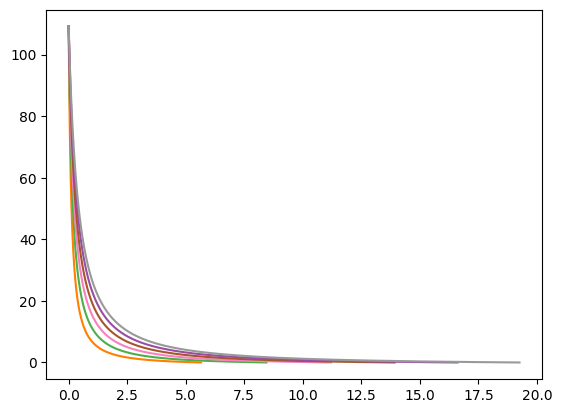

In [223]:
maxF = np.ones((35,1))
maxx = np.ones((35,1))
all_results = []

# %%
## Model Constants
Lp = 0.02 # [m] Initial Pouch Length - From original kellaris paper (2018)
perm0 = 8.85418782e-12#[m-3kg-1s4A2]
permr = 2.2 # for BOPP
Eb = 700e6 #[V/m] the breakdown strength of BOPP
w = 0.08 #[m] from original kellaris paper
t = 30e-6 #[m] Bopp thickness used in initial designs
k = 1000000 #[Nm-1] Achilles tendon average sourced from Litchwark 2005
rho_f = 903 #[kgm-3] Bopp Density TEKRA (2020)
rho_o = 920 #[kgm-3] FR3 Dielectric oil Density Cargill (2018)
alpf = np.pi/2 #[rad] Assume circular cross section on stroke completion
Eper = 0.6 # Percentage of electrode coverage
Va = 10000 # Actuation voltage
N = 1
nn = 7 # Number of series acutators
res = 1000

# %%
## Swept constants
#Va = np.linspace(0,10000,1000) # 0 -> 10kV res: 10V
E = Va/(2*t)
#Eper = np.linspace(0,1,0.01)

## model start
#Lambda for force
lamb = N*Va**2*perm0*permr*w/(4*t)

# Electrode length
Le = Lp*Eper

#optimal fill eqn based on electrode coverage ratio
# !!! MIGHT NOT WORK WITH ARRAY !!!
alpeqn = ((1-Eper)**2)*(2/np.pi) # Easy to calc constant
y = 0.01 # intial guess of angle
it = 0.0001 # iteration
scale = 1.6/it # how many possible
end = int(scale) # int for loop
for i in range(0,end): # over scale
    
    func = (y-np.sin(y)*np.cos(y))/(y**2) - alpeqn # Find value of remaining equation with embedded alpha0
    
    if func >= 0: # root is transition from negative to positive in this case
        alp0 = y - it # previous value before sign flip returned       
        break #root found, stop
    else:
        y += it #move to next guess
        continue


#Height
h = Lp*(np.sin(alp0)/alp0) # Height [m]

#Area w/ restraints 
# !!! MIGHT NOT WORK WITH ARRAY !!!
A = (Lp - Le)**2 /np.pi # Area [m2]
#Fill Volume 
Vol = A*w
#Blocking force
Fb = (lamb)*(np.cos(alp0)/(1-np.cos(alp0)))

Lpf = Lp - Le # Fully Deformed pouch length 

xmax = h - (Lpf*(np.sin(alpf)/alpf)) - Le # max displacement


alp = np.linspace(alp0,alpf,res) #sweep alpha and SET RESOLUTION

# Blocks of lp(alp) eqn sweep
lpnum = 2*A*np.square(alp)
lpdom = (alp - np.sin(alp)*np.cos(alp))
lp2 = lpnum/lpdom
lp = lp2**0.5
lp[0] = Lp # Removes unphysical discretisation error

# electrode length sweep
le = Lp - lp 

# displacement sweep
lpmp = np.sin(alp)/alp # lp multiplier in x
lplpmp = lp*lpmp
X = h - lplpmp - le

# Load of spring
P = k*X

# Force output of actuator
F = lamb*(np.cos(alp)/(1-np.cos(alp)))

# fig, ax = plt.subplots()
# ax.plot(X*1000, F)
# plt.xlabel(r"Tip Displacment $[mm]$")
# plt.ylabel(r"Maximum Load $[N]$")
# plt.title("Series Scaling test")
# %%
# For each actuator in series the load experienced for a given stroke is increased 
# by the mass of the actuators below it.
# All share the same blocking force 
# F - X Defines single actuator dynamics and are used to build series dynamics
out = [None]*4
f_normal = F/(w*t*perm0*permr*E*E) # Normalise force as per Kellaris 2019
strain = (X/(Lp*1))*100 # Calculate Strain
out[0] = X# Stack results for storage
out[1] = F
out[2] = strain 
out[3] = f_normal
maxF[0] = max(F)
maxx[0] = max(X*1000)
print(max(F))
print(max(X*1000))
all_results.append(out)
globalx = X # starts at full X as it will deform for sure as it did for single actuator
#addload = (nn-1)*9.81*(Vol*rho_o+Lp*w*t*2*rho_f) # additional load from actuators below current (nn)
#Look at load value 
xseries = np.zeros((nn,res))
mass = np.zeros((nn,res))
check1 = np.zeros((nn,res))
check2 = np.zeros((nn,res))
xseries[0,:] = X

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                '#f781bf', '#a65628', '#984ea3',
                '#999999', '#e41a1c', '#dede00']
fig, ax = plt.subplots() 
for nn in range(2,8):
    for n in range(1,nn): #for every actuator in series
        # print('actuator')
        # print('n= ' + str(n))
        addload = N*(n-1)*9.81*(Vol*rho_o + Lp*w*t*2*rho_f)
        # print('addload|' + str(addload))
        for i in range(0,len(F)): # for each load value
        
            # print('load value')
            # print('i= ' + str(i))
            mass[n-1,i] = F[i] + addload  # establish an effective mass on single actuator FBD
            # print('mass|' + str(mass[n-1,i]))
            
            if mass[n-1,i] >= Fb: # If the actuator is blocked, move on to next load
                # print('Block|' +str(i) + ' ' + str(n))
                continue
            else: # the actuator can move but by how much?
                # the potential movement is given by graph in previous code
                # the place where the mass roughly equals force is the potential stroke of the actuator
                
                j=0
                while j  < len(F): # sweep F looking for cross point
                    
                    # We want to see the first point where mass > force as this gives us effective stroke
                    if F[j] <= mass[n-1,i]: # check above and if true insert the additional stroke                          
                        xseries[n,i] = X[j]  # Additional displacement at this point is added to global
                        break
                    else:
                        j+=1
                continue
    XX = np.sum(xseries, axis = 0) #sum additional x for each actuator (row)
    #Corresponding displacement
    #build into array for every force
    #add to global

    
    ax.plot(XX*1000,F, label = str(nn-1) + ' Actuator(s)', color = CB_color_cycle[nn-1])
    f_normal = F/(w*t*perm0*permr*E*E) # Normalise force as per Kellaris 2019
    strain = (XX/(Lp*nn))*100 # Calculate Strain
    out = [None]*4
    out[0] = XX# Stack results for storage
    out[1] = F
    print(max(F))
    print(max(XX*1000))
    out[2] = strain 
    out[3] = f_normal
    maxF[nn-1] = max(F)
    maxx[nn-1] = max(XX*1000)
    all_results.append(out)


In [224]:
## Parallel calculations - Literally just multiply force by N

# Pull the values for force from the array 
usethis = all_results[0]
print(max(all_results[0][1]))
Fusethis = usethis[1]
Fnormusethis = usethis[3]
# Multiply them by the appropriate value 
N = 1
for i in range(0,28):
    if i % 7 == 0:
        N += 1
    insert = all_results[i % 7].copy()
   
    insert[1] = Fusethis*N
    insert[3] = Fnormusethis*N

    maxF[i+7] = max(F)
    maxx[i+7] = max(XX*1000)
   
    all_results.append(insert)
    
    
# Add in the right results slot 
print(max(all_results[0][1]))
        
     


109.14644739904533
109.14644739904533


In [225]:
specific_eng = [None]*35 # Empty list to  store specific energies
for i in range(0,35):
    
    F = all_results[i][1].copy()
    X = all_results[i][0].copy()    
    uuact = np.zeros(len(X))
    for j in range(0,res):
        uuact[j] = integrate.trapezoid(F[0:j],X[0:j]) # array of actuator energy till point
    specific_eng[i] = uuact



In [226]:
spring_ks = np.linspace(1000,1000000,100) # Lienar springs for block point finding. 
energys = [[None for j in range(100)] for i in range(35)]
# For each actuator
for i in range (0,35):
    use = all_results[i].copy()
    x = use[0]
    f_act = use[1] 
    blocks = np.zeros((100,1),dtype=int)
    # For each spring, test and save block point 
    j = 0
    for k in spring_ks:
        for ii in range(0,len(x)):
            eng = np.zeros((3,1)) # format is [uact,usee,ratio]
            if k*x[ii] >= f_act[ii]:
                blocks[j] = ii
                eng[0] = integrate.trapezoid(f_act[0:ii],x[0:ii]) # Act Eng
                eng[1] = 0.5*k*x[ii]**2 # Spring Eng
                eng[2] = (eng[1]/eng[0])*100 # Energy storage ratio
                break 
            else:
                continue
        energys[i][j] = eng
        j += 1
        
# Run through x, find block point, what is the energy? 


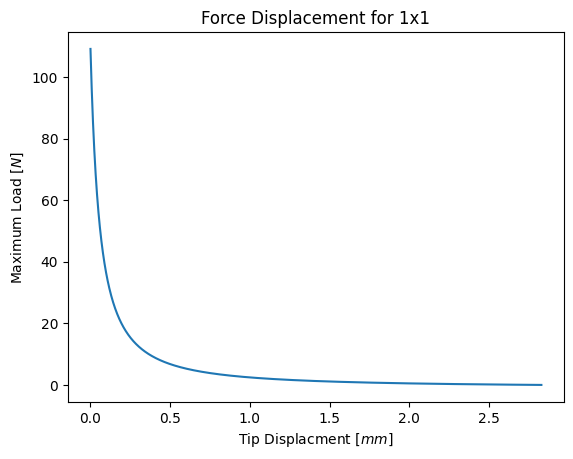

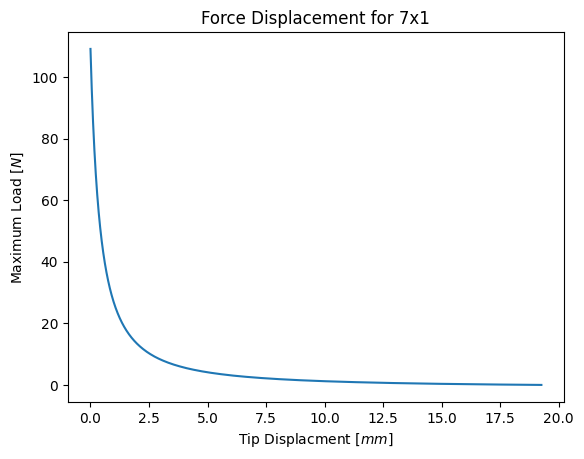

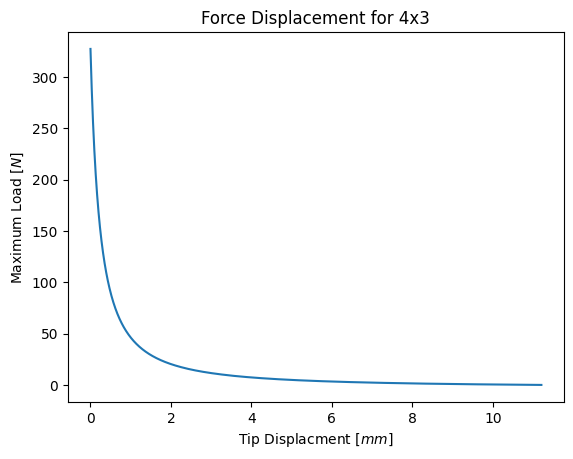

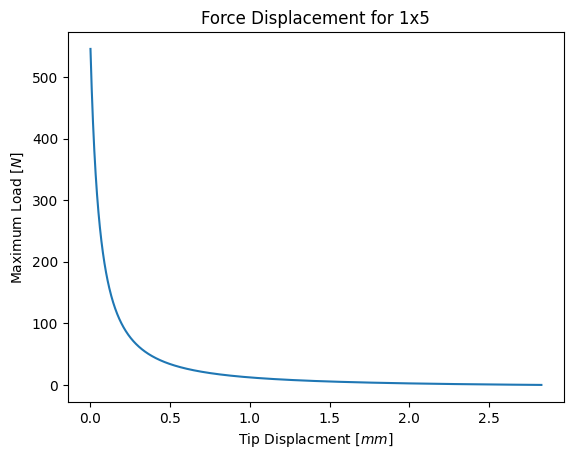

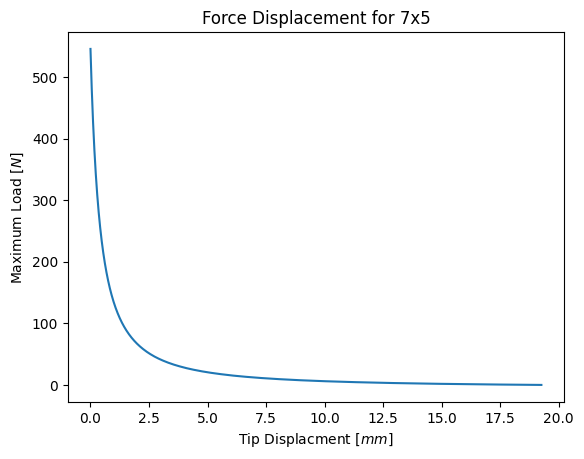

In [227]:
index_use = [0,6,17,28,34]
title_adds = ["1x1","7x1","4x3","1x5","7x5"]
ii = 0
for i in index_use:
    fig, ax = plt.subplots() # Make a figure
    # Plot the f-x
    use = all_results[i].copy()
    F = use[1]
    X = use[0]
    ax.plot(X*1000, F)
    plt.xlabel(r"Tip Displacment $[mm]$")
    plt.ylabel(r"Maximum Load $[N]$")
    plt.title(f"Force Displacement for {title_adds[ii]}")
    ii += 1
    # Plot all springs
    # make a figure
    # plot usee, percentage, spring graph for all 
    
    
